In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from statsforecast.utils import ConformalIntervals

from statsforecast.models import (
    Holt,
    AutoETS,
    HoltWinters,
    SimpleExponentialSmoothing
)

from statsmodels.tsa.exponential_smoothing.ets import ETSModel

/home/grc/arep/time_series/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### 1.0. Exponential Smoothing

#### 1.1. Simple Exponential Smoothing

As previsões geradas pelos modelos de exponential smoothing são médias ponderadas das observações passadas com os pesos decaindo exponencialmente quando as observações vão ficando cada vez mais antigas, ou seja, cada observação possui um pesso associado.

O primeiro método dessa ferramenta implementado foi o SES (Simple exponential smoothing), geralmente é utilizado quando os dados não possuem uma tendência clara ou sazonalidade pois utiliza duas ferramentas clássicas que já foram citadas anteriormente no livro.

Usamos métodos naive para as previsões, e todas as previsões com este método são iguais a última observação disponível, $\hat{y_t} = y_t$, naive assume que a última observação é a mais importante.
Por outro lado, a média $\hat{y_t} = \frac{\sum y_t}{T}$ assume que todas as observações possuem o mesmo grau de importância, ou em outras palavras, possuem o mesmo peso associado a todas as observações.

Ai a galerinha que criou o método pensou em uma solução que não levasse em conta esses dois extremos (A média e o Naive) e sim uma ferramenta que seja um balanço entre esses dois extremos, a primeira proposta foi o SES.

O SES calcula médias ponderadas que decaem exponencialmente ao longo do tempo.

$\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots$

- $\alpha$: Taxa em que os pesos decaem exponencialmente, é o parâmetro de suavização, ($0 <= \alpha <= 1$).
- $\hat{y}_{T+1|T}$: É a média ponderada de todas as observações.

Podemos reescrever a fórmula da seguinte forma:

$\hat{y}_{T+1|T} = \sum_{j=0}^{T-1} \alpha(1-\alpha)^j y_{T-j} + ( 1 - \alpha)^T \ell_{0}$

Onde $\ell_{0}$ É o primeiro valor fittado no tempo 1 e pulamos o primeiro valor da série pois não temos o antecessor dele.

E para ajusatr o SES usamos os minimos quadrados novamente ou outra função para minimizar os erros.

Se $alpha$ é pequeno, proximo de 0 mais peso é dado a observações antigas, caso o $\alpha$ seja proximo de 1, mais peso é dado a observações recentes e quando $\alpha = 1$ temos o método Naive e se $\alpha = 0$ temos o método da média.

Nota, fazemos a previsão para $\hat{y_{t+1}}$, depois disso apenas repetimos essa mesma previsão no futuro $h$ vezes.

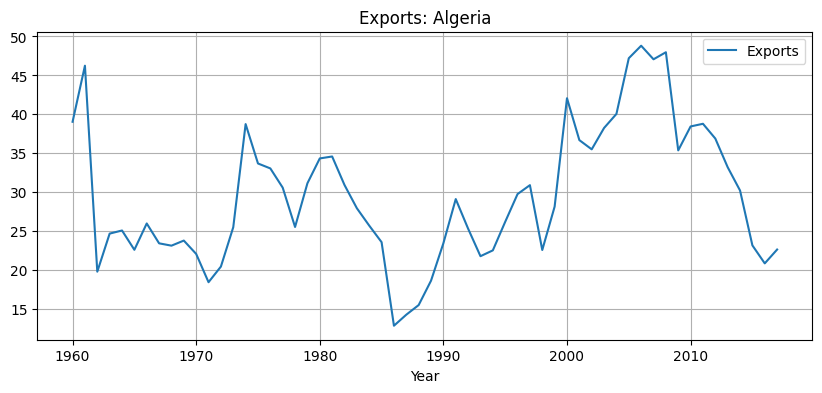

In [2]:
df = pd.read_csv("../data/global_economy.csv", index_col=[0])

df = df[df.Country == "Algeria"].reset_index(drop=True)

df.plot(
    x="Year",
    y="Exports",
    grid=2, figsize=(10, 4),
    title=("Exports: Algeria")
);

Para a nossa felicidade já existe a versão dele no Statsforecast. Entretanto esta meio engraçado esse calculo do intervalo de confiânça deles. xD

In [7]:
ses = SimpleExponentialSmoothing(
    alpha=0.9,
    prediction_intervals=ConformalIntervals(n_windows=2, h=1)
)

ses.fit(df["Exports"].values)

forecast = ses.predict(h=5, level=[90])

forecast = pd.DataFrame(forecast)

forecast["Year"] = [i for i in range(df.Year.max() + 1, df.Year.max() + len(forecast) + 1)]

n_windows: 2
step_size: 1
h: 1
y: [39.0431726  46.24455689 19.79387268 24.68468205 25.08405873 22.60394356
 25.98619752 23.43441677 23.1356346  23.78877682 22.0727334  18.44251915
 20.44956198 25.503663   38.74904361 33.68893622 33.05458393 30.58656693
 25.53583672 31.14830021 34.33846147 34.58725077 30.92485632 27.94180611
 25.71001618 23.58393289 12.85475734 14.27247473 15.50786788 18.63926334
 23.44368508 29.11782217 25.31959428 21.783877   22.53072525 26.19477598
 29.76044833 30.90631138 22.57835401 28.1501165  42.06971832 36.68930475
 35.50453311 38.24882911 40.0532265  47.20519324 48.81068822 47.06816355
 47.97334514 35.37165064 38.44454785 38.78695388 36.89054757 33.20989779
 30.21911743 23.17177829 20.86001063 22.63888685]


In [8]:
forecast.head()

,mean,lo-90,hi-90,Year
0,22.491503,21.082626,23.900379,2018
1,22.491503,21.082626,23.900379,2019
2,22.491503,21.082626,23.900379,2020
3,22.491503,21.082626,23.900379,2021
4,22.491503,21.082626,23.900379,2022


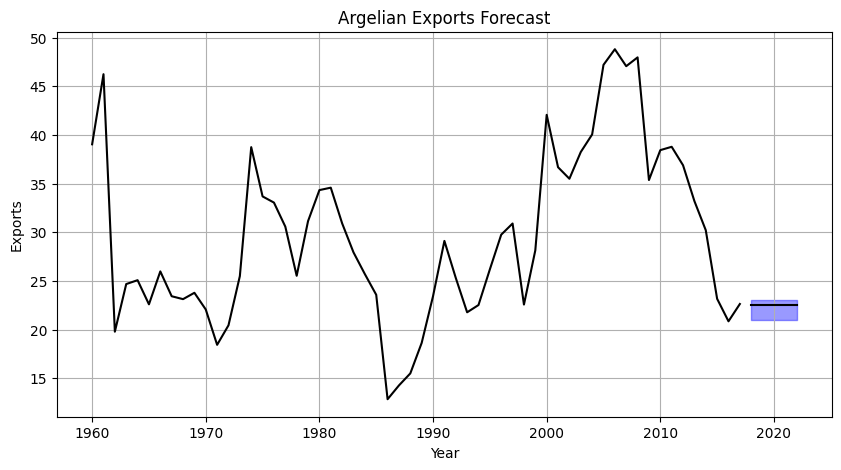

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Year", y="Exports", ax=ax, color="k")
sns.lineplot(forecast, x="Year", y="mean", ax=ax, color="k")

ax.fill_between(
    x=forecast["Year"],
    y1=forecast["lo-90"].astype(int),
    y2=forecast["hi-90"].astype(int),
    color="b",
    label="90",
    alpha=0.4,
)

ax.set_title("Argelian Exports Forecast")
ax.grid(2);

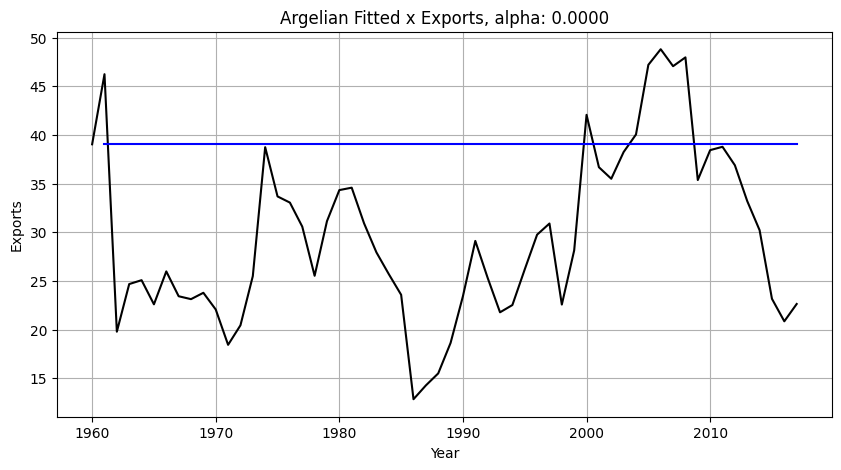

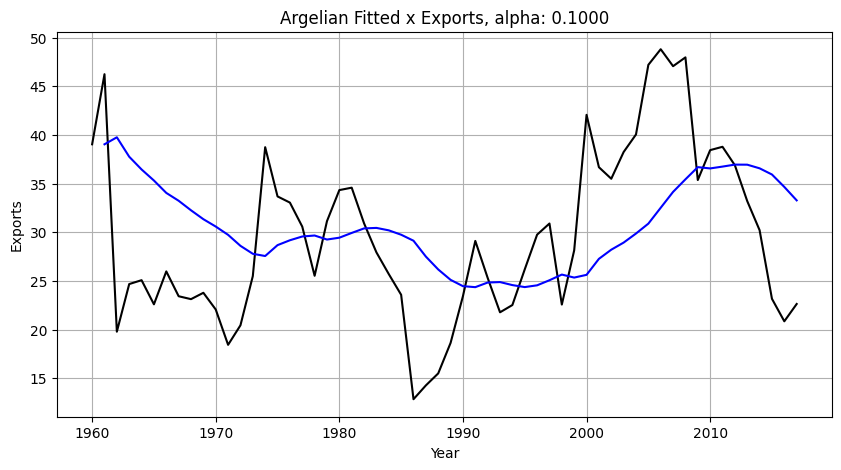

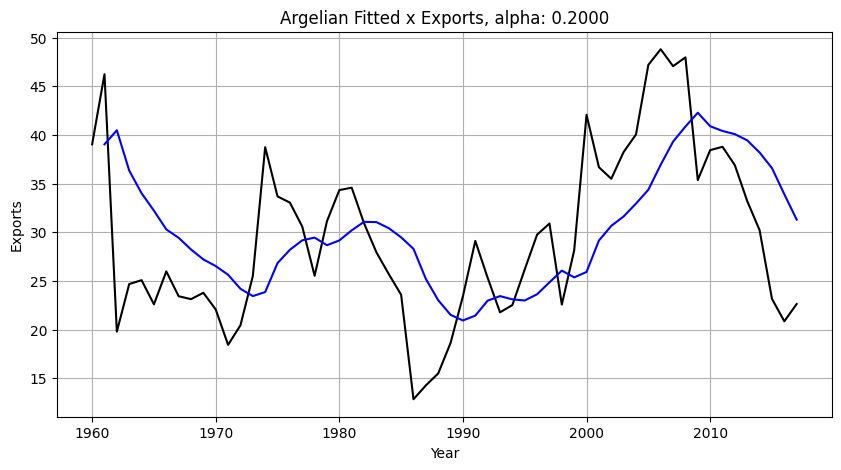

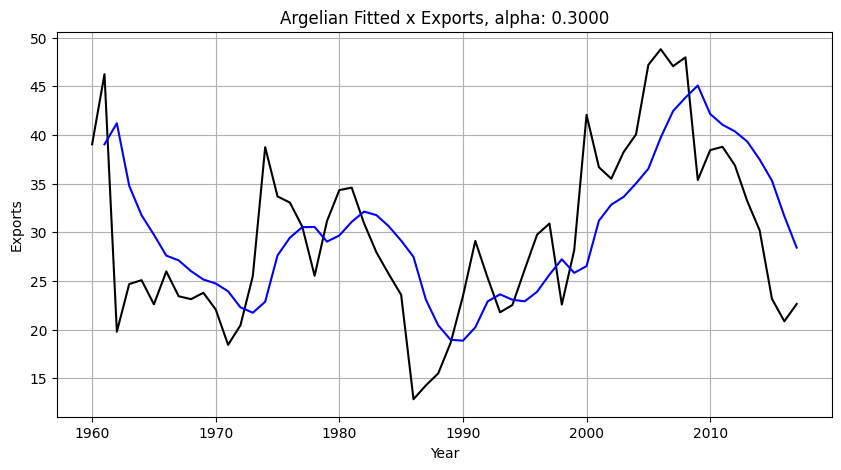

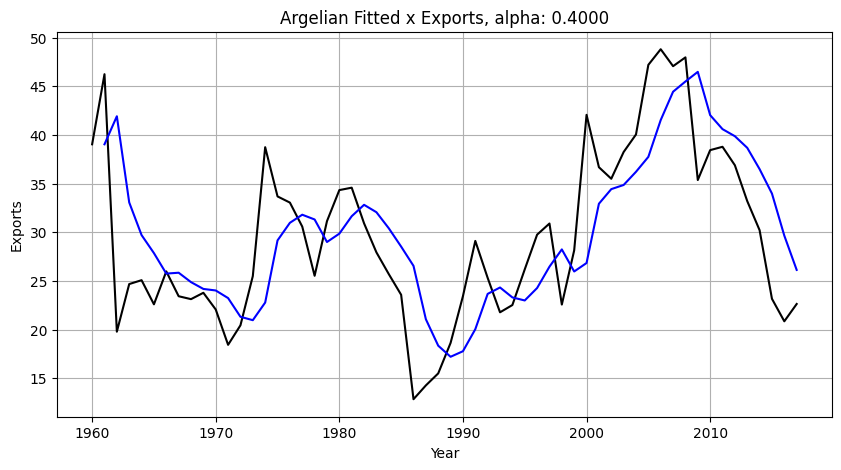

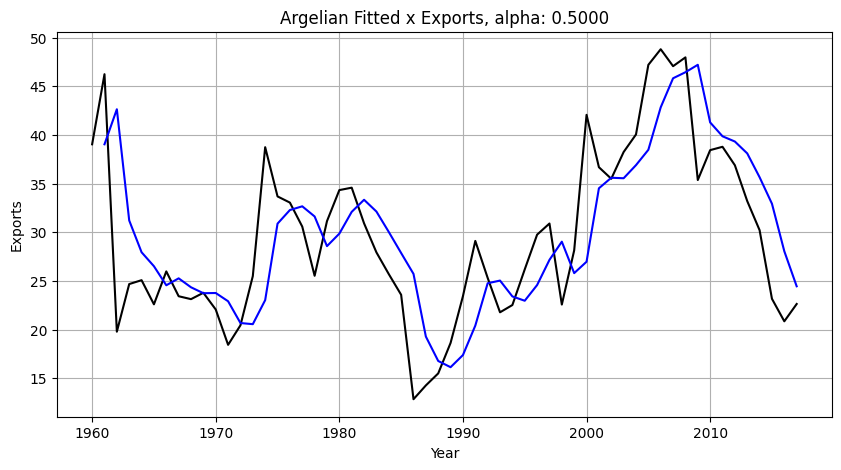

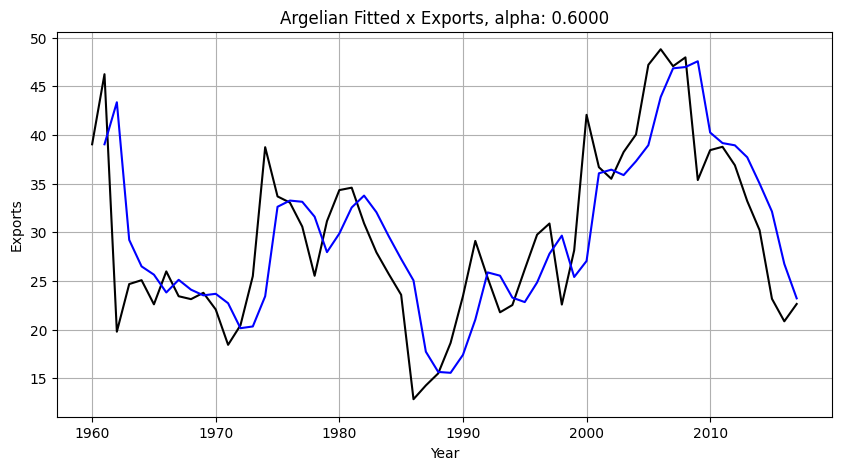

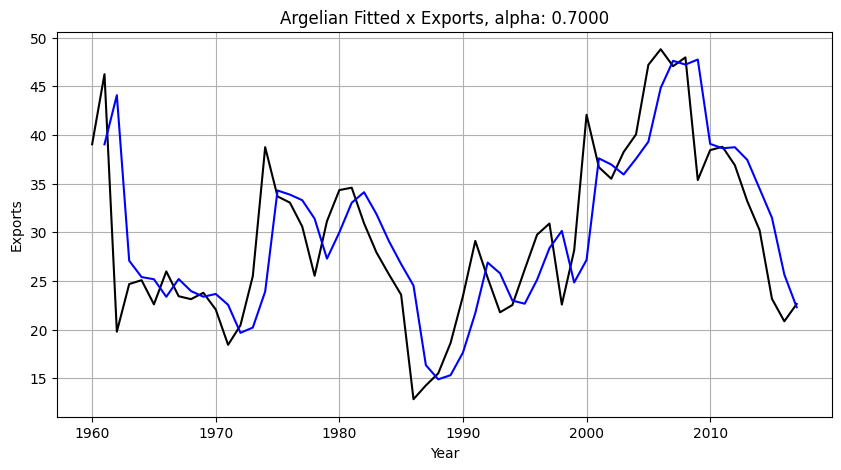

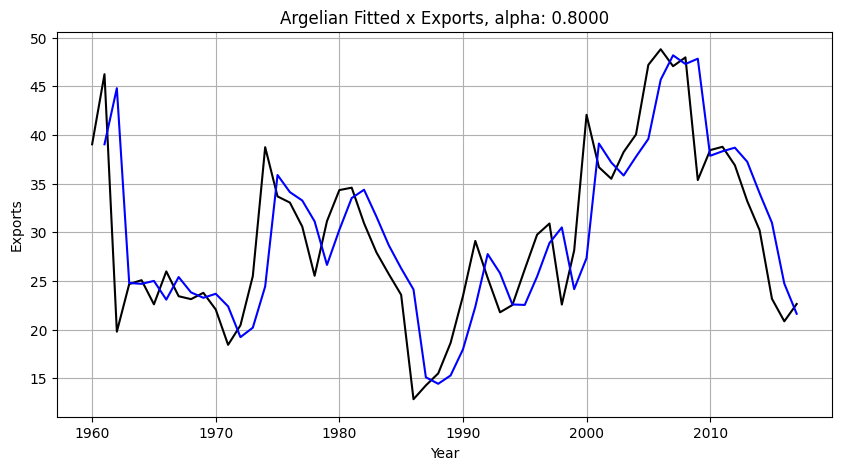

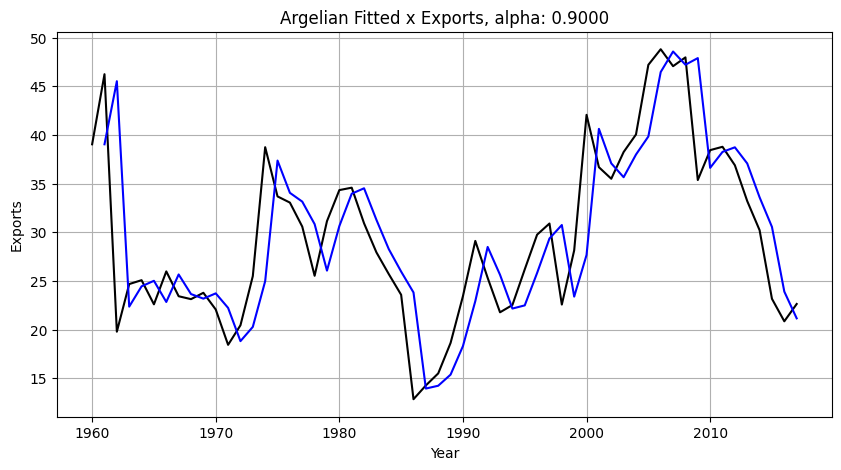

In [25]:
for alpha in np.arange(0, 1, 0.1):
    ses = SimpleExponentialSmoothing(alpha=alpha)
    ses.fit(df["Exports"].values)

    df["fitted"] = ses.model_["fitted"]

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(df, x="Year", y="Exports", ax=ax, color="k")
    sns.lineplot(df, x="Year", y="fitted", ax=ax, color="b")
    ax.set_title(f"Argelian Fitted x Exports, alpha: {alpha:.4f}")
    ax.grid(2);

#### 1.2. Holt's Linear Trend

É uma extensão do SES para levar em conta a tendência da série temporal.

- Equação de Previsão: $\hat{y}_{t+h|t} = \ell_{t} + hb_t$
- Equação do Nível: $l_t = \alpha * y_t + (1 - \alpha) * (\ell_{t-1} + b_{t - 1})$
- Equação da Tendência:  $b_t = \beta^{*} * (l_t - l_{t-1}) + (1- \beta^{*}) * b_{t-1}$

Onde lt é a estimativa do nível (level) no tempo t e bt é a estimativa da tendência no tempo t, alpha é o parametro de suavização das médias (mesmo do SES) e $\beta^{*}$ é o parametro de suavização da tendencia.

Existe uma versão alterantiva do Holt que é o "Damped Trend", pois holt faz uma previsão da tendencia constante já a adição do parâmetro $\phi$ ajuda no ajuste da tendencia para um longo futuro a fim de que a tendencia se converta em uma "flat line" ou vá decaindo no futuro, o parâmetro $\phi$ geralmente é entre 0.8 e 0.98 pois ele é muito forte a poucos dados.

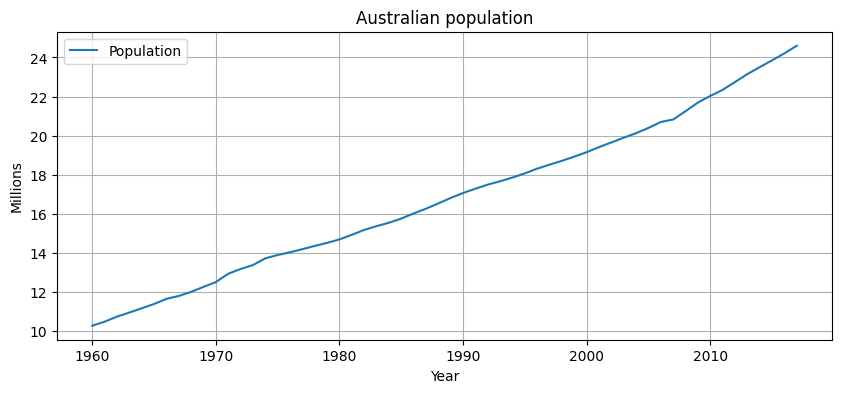

In [3]:
df = pd.read_csv("../data/global_economy.csv", index_col=[0])

df = df[df.Code == "AUS"].reset_index(drop=2)
df["Population"] = df["Population"] / 1e6

df.plot(
    x="Year", y="Population",
    grid=2, figsize=(10, 4),
    title="Australian population",
    ylabel="Millions"
);

In [4]:
hlt = Holt(
    error_type="A",
    season_length=0,
    prediction_intervals=ConformalIntervals(n_windows=10, h=1)
)

hlt.fit(df["Population"].to_numpy())

n_windows: 10
step_size: 1
h: 1
y: [10.276477 10.483    10.742    10.95     11.167    11.388    11.651
 11.799    12.009    12.263    12.507    12.937    13.177    13.38
 13.723    13.893    14.033    14.192    14.358    14.514    14.692
 14.927    15.178    15.369    15.544    15.758    16.0184   16.2639
 16.5322   16.8144   17.0651   17.284    17.495    17.667    17.855
 18.072    18.311    18.517    18.711    18.926    19.153    19.413
 19.6514   19.8954   20.1274   20.3948   20.6979   20.8276   21.2492
 21.6917   22.03175  22.340024 22.742475 23.145901 23.504138 23.850784
 24.210809 24.598933]


Holt

In [5]:
forecast = hlt.predict(h=10, level=[80, 95])

forecast = pd.DataFrame(forecast)
forecast["Year"] = [i for i in range(df.Year.max() + 1, len(forecast) + df.Year.max() + 1)]

In [6]:
forecast

,mean,lo-95,lo-80,hi-80,hi-95,Year
0,24.924995,21.459388,21.997745,27.852245,28.390603,2018
1,25.251065,21.785458,22.323815,28.178315,28.716673,2019
2,25.570614,22.105006,22.643364,28.497864,29.036222,2020
3,25.883772,22.418164,22.956521,28.811022,29.349379,2021
4,26.190666,22.725058,23.263416,29.117916,29.656274,2022
5,26.491423,23.025815,23.564172,29.418673,29.957030,2023
6,26.786164,23.320556,23.858914,29.713414,30.251772,2024
7,27.075011,23.609403,24.147760,30.002261,30.540618,2025
8,27.358080,23.892473,24.430830,30.285330,30.823688,2026
9,27.635488,24.169881,24.708238,30.562739,31.101096,2027


Infelizmente é utilizado o mesmo cálculo para o intervalo de confiânça e eu acredito que esteja meio estranho errado cálculo.

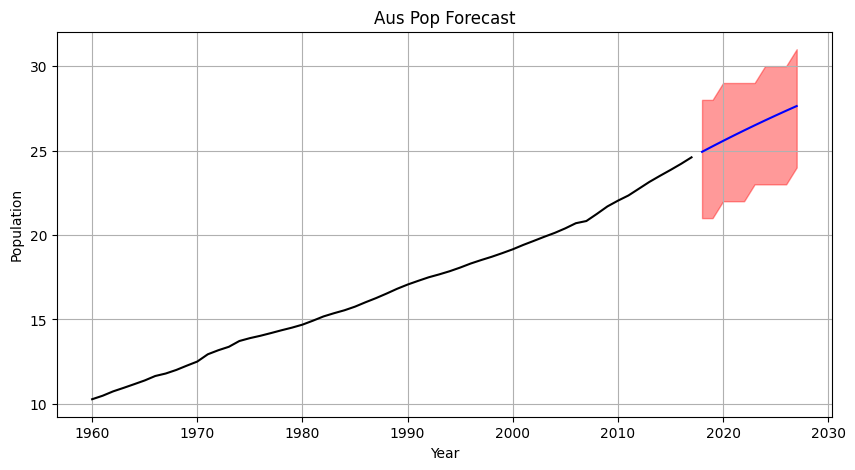

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Year", y="Population", ax=ax, color="k")
sns.lineplot(forecast, x="Year", y="mean", ax=ax, color="b")

ax.fill_between(
    x=forecast["Year"],
    y1=forecast["lo-95"].astype(int),
    y2=forecast["hi-95"].astype(int),
    color="r",
    label="95",
    alpha=0.4,
)

ax.set_title("Aus Pop Forecast")
ax.grid(2);

Irei calcular meu proprio intervalo de confiança para analisar os dois.

In [7]:
hlt.model_

{'loglik': 36.579154245235955,
 'aic': -61.15830849047191,
 'bic': -48.795650427193394,
 'aicc': -59.5112496669425,
 'mse': 0.004883988111380756,
 'amse': 0.017220121505116055,
 'fit': results(x=array([ 0.99988534,  0.20006   ,  0.97999993, 10.02952335,  0.25257775]), fn=-73.15830849047191, nit=342, simplex=array([[ 0.99988513,  0.2000596 ,  0.97999993, 10.02954643,  0.25214678],
        [ 0.9998737 ,  0.20006   ,  0.97999987, 10.02875721,  0.25230729],
        [ 0.99988911,  0.20006   ,  0.97999995, 10.02826794,  0.25280635],
        [ 0.99988362,  0.20005987,  0.97999992, 10.02906412,  0.25210213],
        [ 0.99989141,  0.20006   ,  0.97999995, 10.02853073,  0.25308221],
        [ 0.99988534,  0.20006   ,  0.97999993, 10.02952335,  0.25257775]])),
 'residuals': array([-0.00057253, -0.03594046,  0.02842822, -0.02352664, -0.00528937,
         0.00419549,  0.04971011, -0.07076495,  0.00947075,  0.05563357,
         0.03869877,  0.22121576, -0.00795881, -0.03846499,  0.11390221,
       

In [30]:
M = 0
K = 6
T = len(df)
h = len(forecast)

sigma_hat = np.sqrt((1 / (T - M - K)) * np.sum(hlt.model_["residuals"] ** 2))
#sigma_hat = np.round(sigma_hat, 2)

hsteps = forecast.index.to_numpy() + 1

sigmah = sigma_hat * hsteps
sigmah

array([0.07380735, 0.1476147 , 0.22142206, 0.29522941, 0.36903676,
       0.44284411, 0.51665146, 0.59045882, 0.66426617, 0.73807352])

In [31]:
confidence = .95
alpha = 1 - .95

table_idx = 0.5 - alpha / 2

zscore = stats.norm.ppf(0.5 + table_idx)

zscores = [zscore]
zscores

[1.959963984540054]

In [32]:
dfz = pd.DataFrame(np.array([[zscore for i in range(h)] for zscore in zscores])).T
dfz.columns = [f"C-{int(k * 100)}" for k in [confidence]]

dfz["L-95"] = forecast["mean"] - dfz["C-95"] * sigmah
dfz["U-95"] = forecast["mean"] + dfz["C-95"] * sigmah

In [33]:
forecast = pd.concat([forecast[["Year", "mean"]], dfz], axis=1)

In [34]:
forecast

,Year,mean,C-95,L-95,U-95
0,2018,24.924995,1.959964,24.780335,25.069655
1,2019,25.251065,1.959964,24.961746,25.540385
2,2020,25.570614,1.959964,25.136635,26.004593
3,2021,25.883772,1.959964,25.305133,26.462411
4,2022,26.190666,1.959964,25.467367,26.913965
5,2023,26.491423,1.959964,25.623464,27.359381
6,2024,26.786164,1.959964,25.773546,27.798782
7,2025,27.075011,1.959964,25.917733,28.232289
8,2026,27.358080,1.959964,26.056142,28.660018
9,2027,27.635488,1.959964,26.188891,29.082086


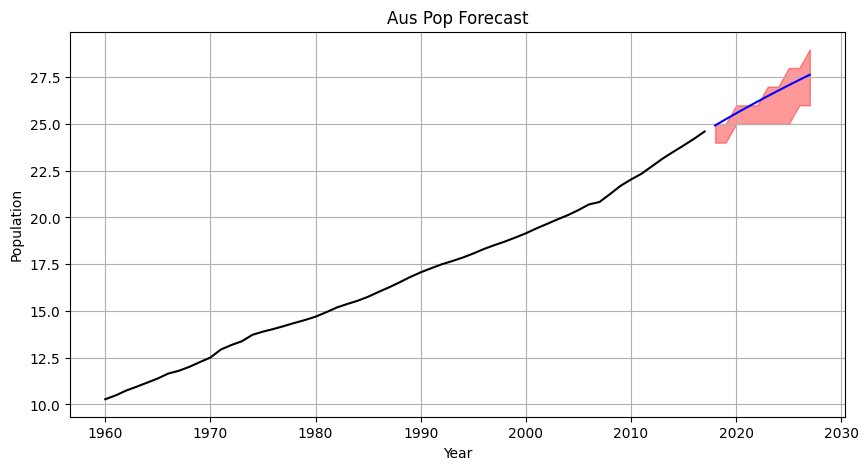

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df, x="Year", y="Population", ax=ax, color="k")
sns.lineplot(forecast, x="Year", y="mean", ax=ax, color="b")

ax.fill_between(
    x=forecast["Year"],
    y1=forecast["L-95"].astype(int),
    y2=forecast["U-95"].astype(int),
    color="r",
    label="95",
    alpha=0.4,
)

ax.set_title("Aus Pop Forecast")
ax.grid(2);

#### 1.3. HoltWinters

É uma extensão do método Holt a fim de introduzir sazonalidade.

$$
\begin{align*}
  \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m}
\end{align*}
$$

Similarmente ao Holt tradicional que foi incluido um parametro de suavização da tendencia, no Holt Winters foi incluido mais um parametro que é o $\gamma$ responsável pela suavização da sazonalidade e é utilizado $m$ para denotar a sazonalidade (m = 12 = mensais, m = 4 quarters...).

Entretanto, existem duas variações do Holt Winters, a versão para sazonalidade multiplicativa e sazonalidade aditiva que variam de acordo com a observação da sazonalidade.

Uma sazonalidade aditiva indica que as variações sazonais são aproximadamente constantes ao longo da série, enquanto a versão multiplicativa é adequada quando a variação da sazonalidade muda ao longo do nível da série. Ambas possuem uma modificação na equação acima para comportar as opções.

Leituras extras:

- https://betterprogramming.pub/exponential-smoothing-methods-for-time-series-forecasting-d571005cdf80

In [2]:
df = pd.read_csv("../data/tourism.csv", index_col=[0])

df = df[df["Purpose"] == "Holiday"].reset_index(drop=2)
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df = (df[["Quarter", "Trips"]].groupby("Quarter").sum() / 1e3).reset_index()

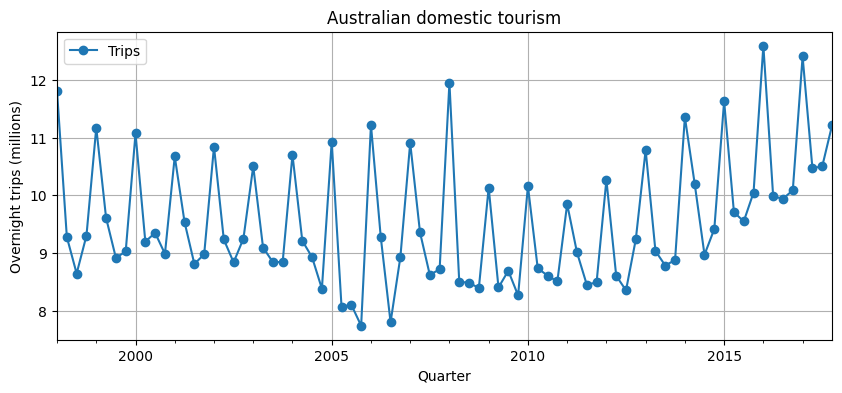

In [3]:
df.plot(
    x="Quarter", y="Trips",
    marker="o",
    grid=2, figsize=(10, 4),
    title="Australian domestic tourism",
    ylabel="Overnight trips (millions)"
);

In [4]:
df = df.set_index("Quarter").resample("Q-JAN").sum()

In [69]:
ets = ETSModel(
    df["Trips"],
    freq='Q-JAN',
    error='Add',
    trend='Add',
    seasonal='Add',
    damped_trend=False,
    initialization_method='heuristic',
).fit()

add_forecast = ets.forecast(4 * 3)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70947D-01    |proj g|=  8.99900D-01

At iterate    1    f=  5.76906D-01    |proj g|=  1.54026D-01

At iterate    2    f=  5.74413D-01    |proj g|=  1.39202D-01

At iterate    3    f=  5.69511D-01    |proj g|=  2.96022D-02

At iterate    4    f=  5.69169D-01    |proj g|=  4.05791D-02

At iterate    5    f=  5.68998D-01    |proj g|=  1.38047D-02

At iterate    6    f=  5.68953D-01    |proj g|=  2.00280D-03

At iterate    7    f=  5.68952D-01    |proj g|=  6.88893D-05

At iterate    8    f=  5.68952D-01    |proj g|=  9.76996D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

Usando o Summary podemos analisar os três componentes fitados do holt winters

In [57]:
ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Trips   No. Observations:                   80
Model:                       ETS(AAA)   Log Likelihood                 -45.516
Date:                Mon, 18 Dec 2023   AIC                             99.032
Time:                        13:46:46   BIC                            108.560
Sample:                    01-31-1998   HQIC                           102.852
                         - 10-31-2017   Scale                            0.183
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.2155      0.070      3.064      0.002       0.078       0.353
smoothing_trend        0.0291      0.012      2.425      0.015       0.006       0.053
smoothing_seasonal     0.0339      0.039      0.875      0.382      -0.042       0.110
===================================================
                   initialization method: heuristic
---------------------------------------------------
initial_level                                9.7040
initial_trend                               -0.0104
initial_seasonal.0                           1.3632
initial_seasonal.1                          -0.1881
initial_seasonal.2                          -0.6752
initial_seasonal.3                          -0.5000
===================================================================================
Ljung-Box (Q):                        3.43   Jarque-Bera (JB):                 1.70
Prob(Q):                              0.90   Prob(JB):                         0.43
Heteroskedasticity (H):               1.77   Skew:                             0.26
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [77]:
ets = ETSModel(
    df["Trips"],
    freq='Q-JAN',
    error='Mul',
    trend='Add',
    seasonal='Mul',
    damped_trend=False,
    initialization_method='heuristic',
).fit()

mul_forecast = ets.forecast(4 * 3)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52803D-01    |proj g|=  8.99900D-01

At iterate    1    f=  5.72683D-01    |proj g|=  1.75439D-01

At iterate    2    f=  5.69583D-01    |proj g|=  1.61092D-01

At iterate    3    f=  5.63121D-01    |proj g|=  5.39774D-02

At iterate    4    f=  5.62650D-01    |proj g|=  6.92864D-02

At iterate    5    f=  5.62203D-01    |proj g|=  2.54989D-02

At iterate    6    f=  5.62097D-01    |proj g|=  1.13576D-02

At iterate    7    f=  5.62049D-01    |proj g|=  1.30126D-03

At iterate    8    f=  5.62049D-01    |proj g|=  1.02961D-03

At iterate    9    f=  5.62049D-01    |proj g|=  2.86660D-05

At iterate   10    f=  5.62049D-01    |proj g|=  4.51861D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [78]:
ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Trips   No. Observations:                   80
Model:                       ETS(MAM)   Log Likelihood                 -44.964
Date:                Mon, 18 Dec 2023   AIC                             97.928
Time:                        13:54:02   BIC                            107.456
Sample:                    01-31-1998   HQIC                           101.748
                         - 10-31-2017   Scale                            0.002
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.2221      0.074      2.981      0.003       0.076       0.368
smoothing_trend        0.0267      0.012      2.276      0.023       0.004       0.050
smoothing_seasonal     0.0338      0.040      0.843      0.399      -0.045       0.112
===================================================
                   initialization method: heuristic
---------------------------------------------------
initial_level                                9.7040
initial_trend                               -0.0104
initial_seasonal.0                           1.1422
initial_seasonal.1                           0.9804
initial_seasonal.2                           0.9297
initial_seasonal.3                           0.9477
===================================================================================
Ljung-Box (Q):                        3.05   Jarque-Bera (JB):                 2.52
Prob(Q):                              0.93   Prob(JB):                         0.28
Heteroskedasticity (H):               1.75   Skew:                             0.26
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

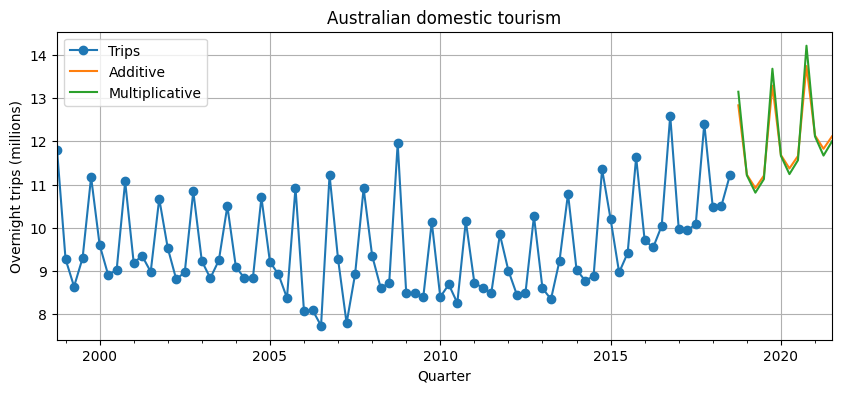

In [79]:
ax = df.plot(
    marker="o",
    figsize=(10, 4),
    title="Australian domestic tourism",
    ylabel="Overnight trips (millions)"
);
ax = add_forecast.plot(
    ax=ax, label="Additive"
)
ax = mul_forecast.plot(
    ax=ax, grid=2, label="Multiplicative"
)

ax.legend();

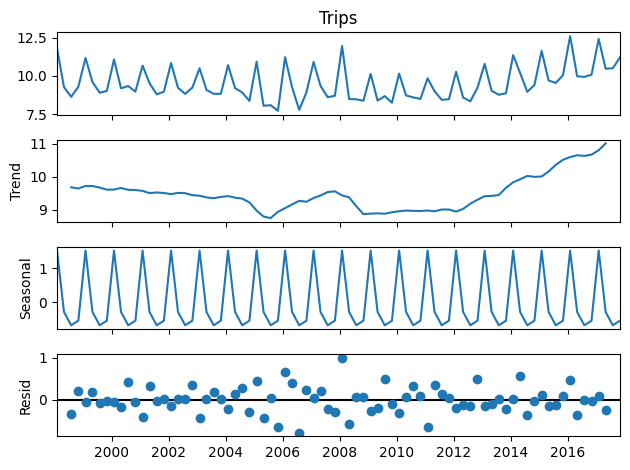

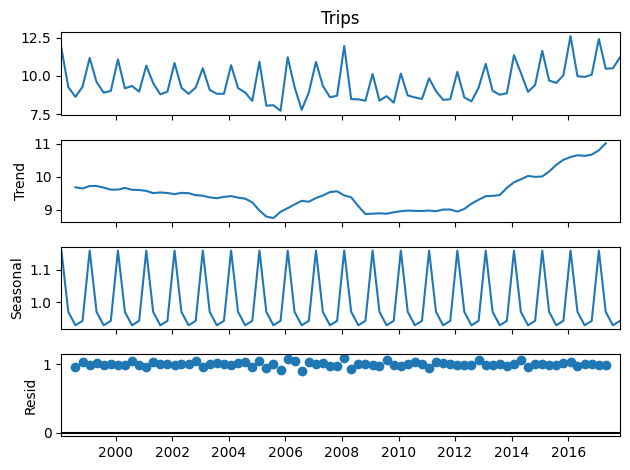

In [88]:
seasonal_decompose(
    df["Trips"],
    period=4,
    model="additive"
).plot();

seasonal_decompose(
    df["Trips"],
    period=4,
    model="multiplicative"
).plot();

#### 1.4. ETS Models

Enquanto em modelos arima estamos utilizando o pacf ou o acf para selecionar o melhor modelo, para modelos ETS (Erro, Tendencia e Sazonalidade) ou chamados de Exponential Smoothing analisamos o resultado da decomposição ou o gráfico da série temporal para selecionar os componentes de suavização adequados.

Existem no total 18 modelos ETS que podemos experimentar, podemos fazer o tuning de cada uma das combinações dos modelos e de cada um dos parâmetro de suavização, ou seja, é bastante modelos, existem soluções que fazem a seleção automática de parâmetros como o AutoETS do statsforecast.

Entretanto, existe uma inovação nos modelos ETS ou Exponential Smoothing que são os modelos "estado de espaço". Diferente dos modelos tradicionais de exponential smoothing, modelos de estado de espaço podem por eles mesmos construirem a distribuição de previsão e gerar intervalos de confiança, ou seja, cada modelo consiste em uma equação de medição que descreve os dados observados e algumas equações de estado que descrevem como os componentes ou estados não observados (nível, tendencia e sazonalidade) mudam ao longo do tempo.

*"Each model consists of a measurement equation that describes the observed data, and some state equations that describe how the unobserved components or states (level, trend, seasonal) change over time. Hence, these are referred to as state space models."*

Ambos possuem a versão aditiva e multiplicativa, o point forecast é identico em ambos, entretanto eles produzem intervalos de previsão diferentes.

Nomeamos esses modelos de "ExponenTial Smoothing", ou ETS(Erro, Tendencia, Sazonalidade).

In [19]:
df = pd.read_csv('../data/pedestrian.csv', index_col=[0])
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.Date_Time = pd.to_datetime(df.Date_Time, format='%Y-%m-%d %H:%M:%S')

df = df[(df.Sensor == 'Southern Cross Station') & 
        (df.Date >= '2016-07-01')
].reset_index(drop=True)

df_forecast = df.loc[(df.Date <= "2016-07-31"), ['Date', 'Count']].groupby('Date').sum()
df_forecast.index.freq = 'D'

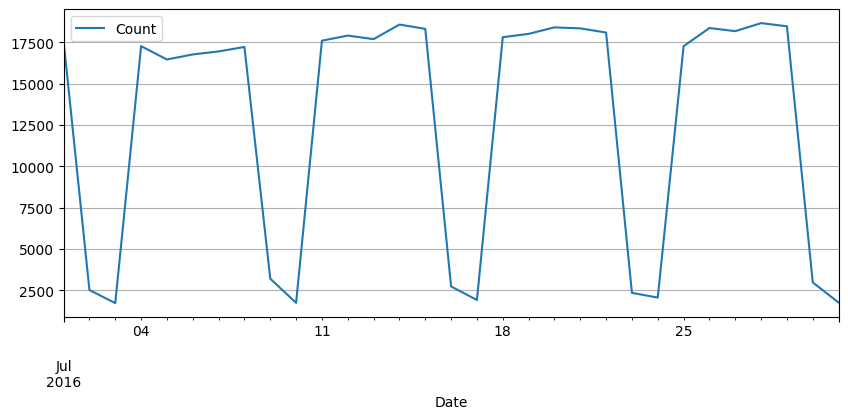

In [21]:
df_forecast.plot(figsize=(10,4), grid=2);

In [64]:
# ETS (A, Ad, A)

ets = ETSModel(
    df_forecast["Count"],
    error='Add',
    trend='Add',
    seasonal='Add',
    initialization_method='heuristic',
    damped_trend=True,
    freq='D'
).fit()

forecast = ets.predict(end='2016-08-21')

ets.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  7.56436D+00    |proj g|=  8.99900D-01

At iterate    1    f=  7.53193D+00    |proj g|=  2.00093D-01

At iterate    2    f=  7.49265D+00    |proj g|=  1.47100D-01
  ys=-6.624E-04  -gs= 3.901E-02 BFGS update SKIPPED

At iterate    3    f=  7.42747D+00    |proj g|=  5.90977D-02

At iterate    4    f=  7.42603D+00    |proj g|=  6.01291D-02

At iterate    5    f=  7.40749D+00    |proj g|=  5.20627D-02

At iterate    6    f=  7.40690D+00    |proj g|=  1.30064D-01

At iterate    7    f=  7.40685D+00    |proj g|=  6.99885D-03

At iterate    8    f=  7.40685D+00    |proj g|=  6.05738D-05

At iterate    9    f=  7.40685D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Count   No. Observations:                   31
Model:                      ETS(AAdA)   Log Likelihood                -229.612
Date:                Tue, 19 Dec 2023   AIC                            469.225
Time:                        08:33:10   BIC                            476.395
Sample:                    07-01-2016   HQIC                           471.562
                         - 07-31-2016   Scale                       158867.862
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.0001        nan        nan        nan         nan         nan
smoothing_trend         1e-08      0.036   2.76e-07      1.000      -0.071       0.071
smoothing_seasonal  9.999e-05        nan        nan        nan         nan         nan
damping_trend          0.9296      0.016     59.104      0.000       0.899       0.960
===================================================
                   initialization method: heuristic
---------------------------------------------------
initial_level                             1.249e+04
initial_trend                              105.5126
initial_seasonal.0                        4618.0561
initial_seasonal.1                       -1.059e+04
initial_seasonal.2                       -1.151e+04
initial_seasonal.3                        4186.5680
initial_seasonal.4                        4210.2942
initial_seasonal.5                        4379.4847
initial_seasonal.6                        4697.8656
===================================================================================
Ljung-Box (Q):                       17.72   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.01   Prob(JB):                         0.31
Heteroskedasticity (H):               0.54   Skew:                            -0.54
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

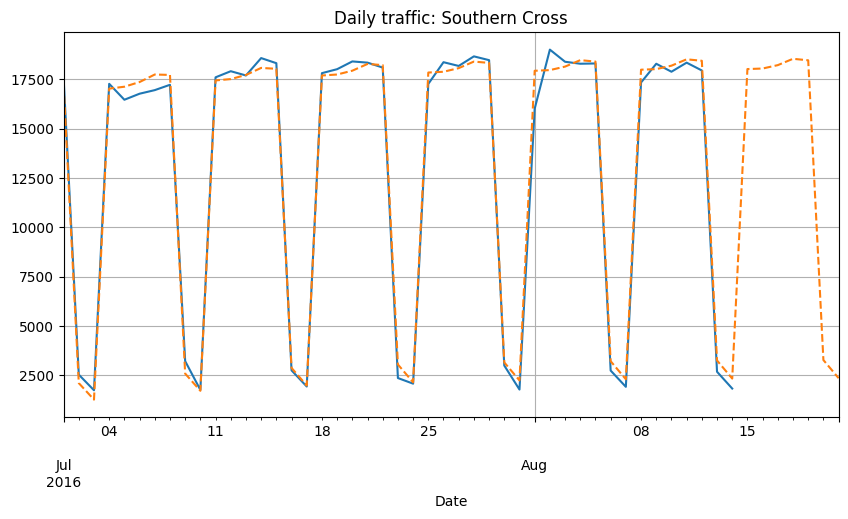

In [60]:
test = df.loc[(df.Date <= '2016-08-14') & (df.Date >= '2016-07-01'), ['Date', 'Count']].groupby('Date').sum()

test.plot(figsize=(10,5), legend='', title="Daily traffic: Southern Cross")
forecast.plot(linestyle='--', grid=2);

In [75]:
r = ets.get_prediction(
    end='2016-08-21',
    dynamic=False,  
    index=None,  
    method=None,
    simulations=1000,
)

In [79]:
r.forecast_variance

array([158867.86220816, 158867.86220816, 158867.86220816, 158867.86220816,
       158867.86220816, 158867.86220816, 158867.86220816, 158867.86220816,
       158867.86220816, 158867.86220816, 158867.86220816, 158867.86220816,
       158867.86220816, 158867.86220816, 158867.86220816, 158867.86220816,
       158867.86220816, 158867.86220816, 158867.86220816, 158867.86220816,
       158867.86220816, 158867.86220816, 158867.86220816, 158867.86220816,
       158867.86220816, 158867.86220816, 158867.86220816, 158867.86220816,
       158867.86220816, 158867.86220816, 158867.86220816, 158867.86220816,
       158867.86379713, 158867.86538638, 158867.86697589, 158867.86856563,
       158867.87015559, 158867.87174576, 158867.87810319, 158867.87969373,
       158867.88128443, 158867.88287528, 158867.88446628, 158867.88605741,
       158867.88764866, 158867.89400811, 158867.89559958, 158867.89719116,
       158867.89878282, 158867.90037457, 158867.9019664 , 158867.9035583 ])

In [98]:
forecast = r.summary_frame(alpha=0.05)
forecast.reset_index(inplace=True)

In [99]:
forecast.head()

,index,mean,pi_lower,pi_upper
0,2016-07-01,17207.324795,16426.117812,17988.531778
1,2016-07-02,2095.214399,1314.007416,2876.421382
2,2016-07-03,1258.311825,477.104841,2039.518808
3,2016-07-04,17030.722447,16249.515463,17811.929430
4,2016-07-05,17127.731248,16346.524265,17908.938231


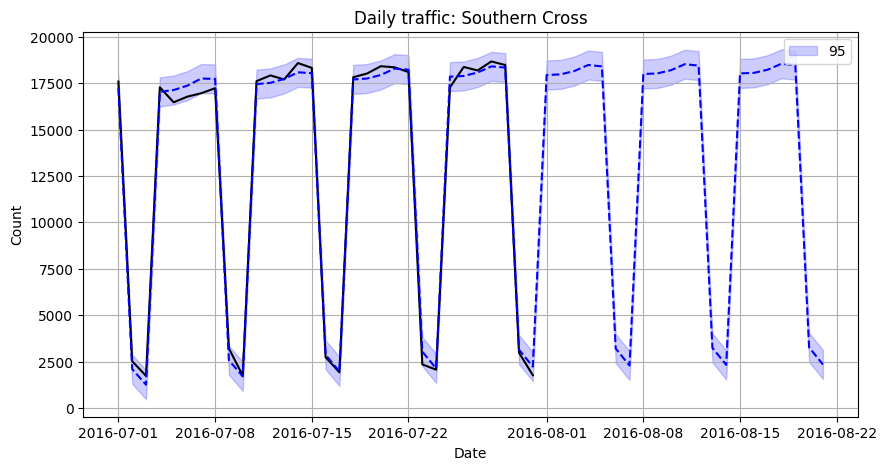

In [101]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df_forecast.reset_index(), x="Date", y="Count", ax=ax, color="k")
sns.lineplot(forecast, x="index", y="mean", ax=ax, color="b", linestyle="--")

ax.fill_between(
    x=forecast["index"],
    y1=forecast["pi_lower"].astype(int),
    y2=forecast["pi_upper"].astype(int),
    color="b",
    label="95",
    alpha=0.2,
)

ax.set_title("Daily traffic: Southern Cross")
ax.grid(2);
ax.legend();

#### 1.5. ETS Model Selection

Eu deveria separar em treino e teste e fazer o cross validation para selecionar o melhor método.

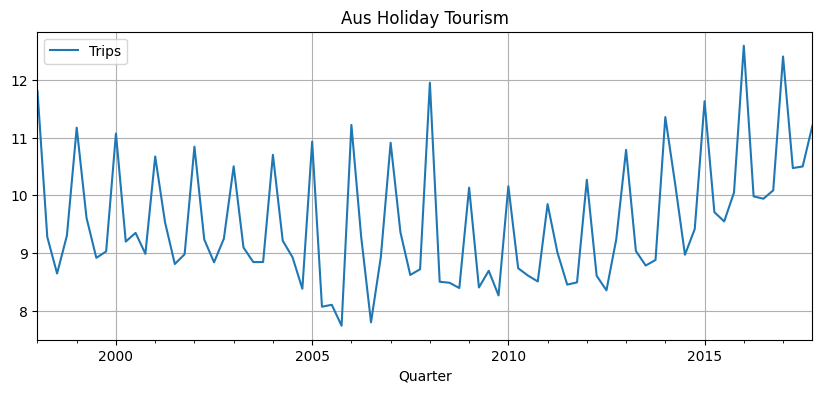

In [2]:
df = pd.read_csv("../data/tourism.csv", index_col=[0])

df = df[df["Purpose"] == "Holiday"].reset_index(drop=2)
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df = (df[["Quarter", "Trips"]].groupby("Quarter").sum() / 1e3).reset_index()

df.plot(x="Quarter", y="Trips", grid=2, title="Aus Holiday Tourism", figsize=(10, 4));

##### 1.5.1. AutoETS

In [142]:
aets = AutoETS(season_length=4)

aets.fit(df["Trips"].to_numpy())

ets_output = aets.model_

{"model": ets_output["method"],
"aic": ets_output["aic"],
"aicc": ets_output["aicc"],
"bic": ets_output["bic"],
"mse": ets_output["mse"],
"amse": ets_output["amse"]}

{'model': 'ETS(M,N,M)',
 'aic': 225.9331736048222,
 'aicc': 227.48872916037774,
 'bic': 242.60736004753937,
 'mse': 0.18105536472014735,
 'amse': 0.1966823115674865}

In [159]:
forecast = pd.DataFrame(
    pd.date_range(
        start=df.Quarter.max(),
        end=df.Quarter.max() + pd.DateOffset(years=4),
        freq="Q-JAN"
    )
)[1:]

forecast["mean"] = aets.predict(h=len(forecast))["mean"]
forecast.columns = ["Quarter", "Mean"]

In [167]:
dfp = df.set_index("Quarter").resample("Q-JAN").sum().reset_index()

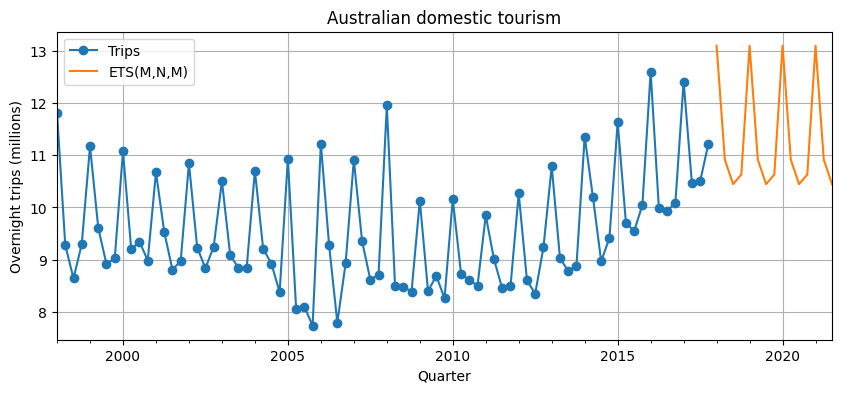

In [170]:
ax = dfp.plot(
    x="Quarter", y="Trips",
    marker="o",
    figsize=(10, 4),
    title="Australian domestic tourism",
    ylabel="Overnight trips (millions)"
);

ax = forecast.plot(
    x="Quarter", y="Mean", grid=2,
    ax=ax, label=f"{ets_output['method']}"
)

ax.legend();

##### 1.5.2. Statsmodels

In [3]:
df = df.set_index("Quarter").resample("Q-JAN").sum()

df.head()

,Trips
Quarter,
1998-01-31,11.806038
1998-04-30,9.275662
1998-07-31,8.642489
1998-10-31,9.299524
1999-01-31,11.172027


In [4]:
method = "MNA"

In [5]:
ets = ETSModel(
    df["Trips"],
    freq='Q-JAN',
    error='Mul',
    trend=None,
    seasonal='Add',
    damped_trend=False,
    initialization_method='heuristic',
).fit()

forecast = ets.forecast(4 * 3)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60443D-01    |proj g|=  8.99900D-01

At iterate    1    f=  6.19340D-01    |proj g|=  1.85826D-01

At iterate    2    f=  5.85115D-01    |proj g|=  1.57968D-01

At iterate    3    f=  5.82883D-01    |proj g|=  1.05507D-02

At iterate    4    f=  5.82859D-01    |proj g|=  6.18954D-03

At iterate    5    f=  5.82849D-01    |proj g|=  5.36815D-04

At iterate    6    f=  5.82849D-01    |proj g|=  1.12055D-04

At iterate    7    f=  5.82849D-01    |proj g|=  9.99201D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [6]:
ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Trips   No. Observations:                   80
Model:                       ETS(MNA)   Log Likelihood                 -46.628
Date:                Tue, 19 Dec 2023   AIC                             99.256
Time:                        15:45:02   BIC                            106.402
Sample:                    01-31-1998   HQIC                           102.121
                         - 10-31-2017   Scale                            0.002
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.3293      0.069      4.740      0.000       0.193       0.465
smoothing_seasonal     0.0239      0.036      0.669      0.504      -0.046       0.094
===================================================
                   initialization method: heuristic
---------------------------------------------------
initial_level                                9.7040
initial_seasonal.0                           1.3632
initial_seasonal.1                          -0.1881
initial_seasonal.2                          -0.6752
initial_seasonal.3                          -0.5000
===================================================================================
Ljung-Box (Q):                        5.49   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.70   Prob(JB):                         0.76
Heteroskedasticity (H):               2.01   Skew:                            -0.01
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

No livro é mostrado outras formas de calcular o intervalo de previsão com fórmulas de bolso.

Mas podemos usar o statsmodels.

In [8]:
r = ets.get_prediction(
    end=forecast.index.max().strftime("%Y-%m-%d"),
    dynamic=False,
    index=None,
    
    # Caso vc queira intervalos simulados de previsão
    # basta mudar o método
    method=None,
    simulate_repetitions=10_000
)

In [9]:
for alpha in [0.05, 0.10, 0.20]:
    display(r.summary_frame(alpha=alpha).head())

,mean,mean_numerical,pi_lower,pi_upper
1998-01-31,11.067276,11.066424,10.069248,12.060404
1998-04-30,9.759189,9.757735,8.900214,10.643744
1998-07-31,9.112892,9.111906,8.306660,9.944528
1998-10-31,9.133221,9.129282,8.313176,9.948806
1999-01-31,11.068821,11.077095,10.093376,12.059399


,mean,mean_numerical,pi_lower,pi_upper
1998-01-31,11.067276,11.066424,10.220399,11.902619
1998-04-30,9.759189,9.757735,9.038824,10.487327
1998-07-31,9.112892,9.111906,8.418610,9.822332
1998-10-31,9.133221,9.129282,8.449939,9.821156
1999-01-31,11.068821,11.077095,10.250965,11.899933


,mean,mean_numerical,pi_lower,pi_upper
1998-01-31,11.067276,11.066424,10.410329,11.707087
1998-04-30,9.759189,9.757735,9.189991,10.317446
1998-07-31,9.112892,9.111906,8.566373,9.662468
1998-10-31,9.133221,9.129282,8.597281,9.672432
1999-01-31,11.068821,11.077095,10.434834,11.732390


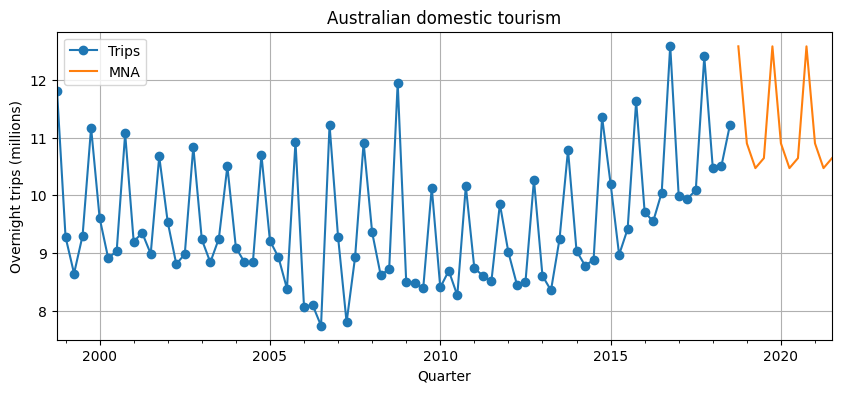

In [37]:
ax = df.plot(
    y="Trips",
    marker="o",
    figsize=(10, 4),
    title="Australian domestic tourism",
    ylabel="Overnight trips (millions)"
);

ax = forecast.plot(
    grid=2,
    ax=ax, label=method
)

ax.legend();